<a href="https://colab.research.google.com/github/csharpshooter/EVA/blob/master/A6/A6_NoRegularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Tue Feb 25 22:06:59 2020


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Feb 25 22:06:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   67C    P3    28W /  N/A |   1690MiB /  8117MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#   print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#   print('re-execute this cell.')
# else:
#   print('You are using a high-RAM runtime!')

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

%config IPCompleter.greedy=True

In [0]:
print(torch.__version__)

1.4.0


In [0]:
reg_type="None"
# reg_type="L1"
# reg_type="L2"
# reg_type="L1L2"

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms) 
#If True, creates dataset from training.pt, otherwise from test.pt.

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0006)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


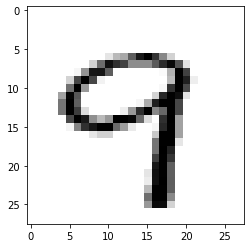

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

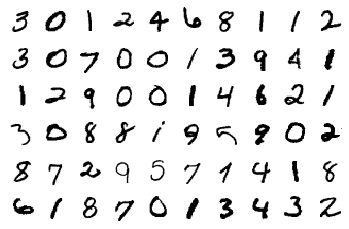

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [0]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1306)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
#------------------------------------------------------------------------------------------------------------------    
        # Input Block RF =1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 28 RF = 3
#------------------------------------------------------------------------------------------------------------------    
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 28 RF = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 28 RF = 7
#------------------------------------------------------------------------------------------------------------------    
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14 RF = 8
        
#------------------------------------------------------------------------------------------------------------------   
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), 
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 12 RF = 12
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),  
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10 RF = 16
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 8 RF = 20

        
#------------------------------------------------------------------------------------------------------------------    
        # TRANSITION BLOCK 2
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 4 RF = 22
        
#------------------------------------------------------------------------------------------------------------------  
        # OUTPUT BLOCK 
    
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(25),
            nn.ReLU()
        ) # output_size = 2 RF = 30
    
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),

        ) # output_size = 2 RF = 30

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 1 RF = 34
#------------------------------------------------------------------------------------------------------------------  
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Defaulting to user installation because normal site-packages is not writeable
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             900
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
            Conv2d-7           [-1, 15, 28, 28]           1,350
       BatchNorm2d-8           [-1, 15, 28, 28]              30
              ReLU-9           [-1, 15, 28, 28]               0
        MaxPool2d-10           [-1, 15, 14, 14]               0
           Conv2d-11           [-1, 10, 12, 12]           1,350
      BatchNorm2d-12           [-1, 10, 12, 12]              20
             ReLU-13

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)  

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    t_acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    t_acc = 100. * correct / len(test_loader.dataset)
    return t_acc

# Let's Train and test our model

In [0]:
lr_data = []
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=1, 
            verbose=True, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    train(model, device, train_loader, optimizer, epoch)
    t_acc_epoch = test(model, device, test_loader)
    scheduler.step(t_acc_epoch)
    for param_groups in optimizer.param_groups:
         print("Learning rate =",param_groups['lr']," for epoch: ",epoch+1) # print LR for different epochs
         lr_data.append(param_groups['lr'])

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06088431552052498 Batch_id=468 Accuracy=94.86: 100%|██████████| 469/469 [00:04<00:00, 102.75it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9864/10000 (98.64%)

Learning rate = 0.03  for epoch:  1
EPOCH: 1


Loss=0.038213618099689484 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:04<00:00, 111.13it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9855/10000 (98.55%)

Learning rate = 0.03  for epoch:  2
EPOCH: 2


Loss=0.03475502133369446 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:04<00:00, 110.99it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9907/10000 (99.07%)

Epoch     3: reducing learning rate of group 0 to 1.5000e-03.
Learning rate = 0.0015  for epoch:  3
EPOCH: 3


Loss=0.012231831438839436 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:04<00:00, 108.57it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9939/10000 (99.39%)

Learning rate = 0.0015  for epoch:  4
EPOCH: 4


Loss=0.00843241810798645 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:04<00:00, 109.32it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

Epoch     5: reducing learning rate of group 0 to 7.5000e-05.
Learning rate = 7.500000000000001e-05  for epoch:  5
EPOCH: 5


Loss=0.015262882225215435 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:04<00:00, 110.43it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

Learning rate = 7.500000000000001e-05  for epoch:  6
EPOCH: 6


Loss=0.02394765056669712 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:04<00:00, 108.07it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

Epoch     7: reducing learning rate of group 0 to 3.7500e-06.
Learning rate = 3.7500000000000005e-06  for epoch:  7
EPOCH: 7


Loss=0.00568378483876586 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:04<00:00, 109.15it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9945/10000 (99.45%)

Learning rate = 3.7500000000000005e-06  for epoch:  8
EPOCH: 8


Loss=0.00817874539643526 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:04<00:00, 102.59it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

Epoch     9: reducing learning rate of group 0 to 1.8750e-07.
Learning rate = 1.8750000000000003e-07  for epoch:  9
EPOCH: 9


Loss=0.03606380149722099 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:04<00:00, 100.26it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9945/10000 (99.45%)

Learning rate = 1.8750000000000003e-07  for epoch:  10
EPOCH: 10


Loss=0.0036770750302821398 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:04<00:00, 100.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

Epoch    11: reducing learning rate of group 0 to 9.3750e-09.
Learning rate = 9.375000000000003e-09  for epoch:  11
EPOCH: 11


Loss=0.010681559331715107 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:04<00:00, 100.74it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

Learning rate = 9.375000000000003e-09  for epoch:  12
EPOCH: 12


Loss=0.004176020622253418 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:04<00:00, 100.50it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

Learning rate = 9.375000000000003e-09  for epoch:  13
EPOCH: 13


Loss=0.02570919133722782 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:04<00:00, 100.61it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  14
EPOCH: 14


Loss=0.0040182569064199924 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:04<00:00, 101.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

Learning rate = 9.375000000000003e-09  for epoch:  15
EPOCH: 15


Loss=0.022804027423262596 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:04<00:00, 101.93it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)

Learning rate = 9.375000000000003e-09  for epoch:  16
EPOCH: 16


Loss=0.006043190602213144 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:04<00:00, 102.39it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

Learning rate = 9.375000000000003e-09  for epoch:  17
EPOCH: 17


Loss=0.01948474533855915 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:04<00:00, 101.09it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

Learning rate = 9.375000000000003e-09  for epoch:  18
EPOCH: 18


Loss=0.024640709161758423 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:04<00:00, 97.96it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  19
EPOCH: 19


Loss=0.015356426127254963 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:04<00:00, 99.47it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  20
EPOCH: 20


Loss=0.040580715984106064 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:05<00:00, 88.59it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  21
EPOCH: 21


Loss=0.12440688163042068 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:04<00:00, 93.90it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9938/10000 (99.38%)

Learning rate = 9.375000000000003e-09  for epoch:  22
EPOCH: 22


Loss=0.005553302820771933 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:04<00:00, 99.74it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

Learning rate = 9.375000000000003e-09  for epoch:  23
EPOCH: 23


Loss=0.003779468359425664 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:04<00:00, 101.27it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9942/10000 (99.42%)

Learning rate = 9.375000000000003e-09  for epoch:  24
EPOCH: 24


Loss=0.006073623895645142 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:05<00:00, 91.87it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  25
EPOCH: 25


Loss=0.0273056011646986 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:05<00:00, 92.59it/s]    
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9945/10000 (99.45%)

Learning rate = 9.375000000000003e-09  for epoch:  26
EPOCH: 26


Loss=0.029050549492239952 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:05<00:00, 93.75it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9945/10000 (99.45%)

Learning rate = 9.375000000000003e-09  for epoch:  27
EPOCH: 27


Loss=0.014934887178242207 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:05<00:00, 90.28it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

Learning rate = 9.375000000000003e-09  for epoch:  28
EPOCH: 28


Loss=0.010944877751171589 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:05<00:00, 89.37it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)

Learning rate = 9.375000000000003e-09  for epoch:  29
EPOCH: 29


Loss=0.02954970858991146 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:05<00:00, 90.88it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

Learning rate = 9.375000000000003e-09  for epoch:  30
EPOCH: 30


Loss=0.014717821963131428 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:05<00:00, 90.10it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  31
EPOCH: 31


Loss=0.05904779210686684 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:05<00:00, 89.60it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

Learning rate = 9.375000000000003e-09  for epoch:  32
EPOCH: 32


Loss=0.048459555953741074 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:05<00:00, 92.42it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9944/10000 (99.44%)

Learning rate = 9.375000000000003e-09  for epoch:  33
EPOCH: 33


Loss=0.034112993627786636 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:05<00:00, 89.33it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

Learning rate = 9.375000000000003e-09  for epoch:  34
EPOCH: 34


Loss=0.01365796197205782 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:05<00:00, 84.09it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

Learning rate = 9.375000000000003e-09  for epoch:  35
EPOCH: 35


Loss=0.0187192615121603 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:05<00:00, 82.20it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  36
EPOCH: 36


Loss=0.004263237118721008 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:05<00:00, 86.23it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

Learning rate = 9.375000000000003e-09  for epoch:  37
EPOCH: 37


Loss=0.0032174636144191027 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:05<00:00, 91.11it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

Learning rate = 9.375000000000003e-09  for epoch:  38
EPOCH: 38


Loss=0.017071491107344627 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:05<00:00, 85.56it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

Learning rate = 9.375000000000003e-09  for epoch:  39
EPOCH: 39


Loss=0.01934611238539219 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:05<00:00, 87.71it/s]  



Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

Learning rate = 9.375000000000003e-09  for epoch:  40


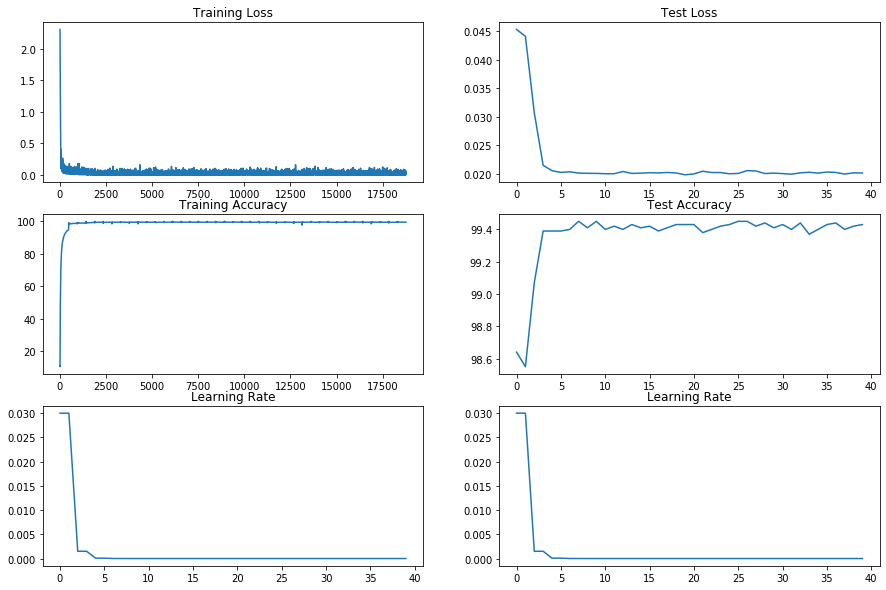

In [0]:
fig, axs = plt.subplots(nrows=3, ncols=2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
axs[2, 0].plot(lr_data)
axs[2, 0].set_title("Learning Rate")
axs[2, 1].plot(lr_data)
axs[2, 1].set_title("Learning Rate")
plt.show()

In [0]:
import os
import datetime
# Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
t = datetime.datetime.today()
PATH = "/home/abhijit/Downloads/PytorchModels/EVA/A6/A6-" + reg_type + "-"+ str(t) +".pth"
print(t)
print(PATH)

2020-02-25 22:10:47.703768
/home/abhijit/Downloads/PytorchModels/EVA/A6/A6-None-2020-02-25 22:10:47.703768.pth


In [0]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'train_acc': train_acc,
            'test_losses': test_losses,
            'test_acc': test_acc,
            'lr_data': lr_data,
            }, PATH)
